## Install and imports

Explicación de los modulos usados y por que

### Imports

In [94]:
import pandas as pd
import numpy as np
import warnings
import re
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### Settings

In [95]:
# Seaborn style
sn.set_theme()


# Color palette for Plotly
palette = ["#FC645F", "#A8E4A0", "#7088FF", "#FEB1AF"]


# Silencing warnings
warnings.filterwarnings('ignore')


# Setting max columns to six
pd.options.display.max_columns = 6


# Setting max rows to ten
pd.options.display.max_rows = 10


# Loading dataset
file = 'dataset.csv'
df = pd.read_csv(file)

### Funciones



<b>viz_categorical</b> <br>
Esta función dinamicamente encuentra las variables catégoricas (con un value count de 25 o menos) de un dataframe y plotea los distintos valores en la serie. La utilizaremos para encontrar las variables categóricas sino tambien para marcar aquellas que son constantes, es decir, cuentan con un solo valor.

In [96]:
def viz_categorical(dataframe):
    column_list = [column for column in dataframe.columns if len(dataframe[column].value_counts().index)>0 and len(dataframe[column].value_counts().index)<=40]
    context_dataframe = dataframe[column_list]
    
    
    # Calculating row index for plot based on x * 3 design
    if context_dataframe.shape[1] % 3 != 0:
        rows = round(context_dataframe.shape[1] / 3) + 1
    else:
        rows = round(context_dataframe.shape[1] / 3)


    # Plot constants
    fig, axes = plt.subplots(rows,3, figsize=(15, 10))
    fig.suptitle('Categorical variables')
    
    col_iter = 0
    row_iter = 0


    # Plotting
    for column, (i, ax) in zip(context_dataframe.columns, enumerate(fig.axes)):
        col_loc = context_dataframe.columns.get_loc(column)
        sn.barplot(x=context_dataframe[column].value_counts().index, y=context_dataframe[column].value_counts().values, ax=ax)
        ax.title.set_text(column)
        if len(context_dataframe[column].value_counts().index) > 5:
            ax.set_xticks([])

In [97]:


def dat_insights(dataframe,sheet_name=False,rtn=True,dat=False,date_parse=False):
  if type(dataframe) == str:
    dataframe = data_capture(dataframe,sheet_name,date_parse).capture()
  if dat is not False:
    dataframe = column_cleaner(dataframe,[column for column in dataframe.columns if column in dat])
  null_values = dataframe.isnull().sum().sort_values(ascending=False)
  nulls_sum = (dataframe.isnull().sum()).sum()
  fields_sum = (dataframe.shape[0] * dataframe.shape[1]) - nulls_sum
  nulls_percentile = max(null_values)
  fills_percentile = dataframe.shape[0] - nulls_percentile
  if null_values.shape[0] > 15:
    null_values = null_values[null_values != 0]
  else:
    pass
  fig = make_subplots(rows=2,
                      cols=2,
                      subplot_titles=["<b>CORRECT ENTRIES</b>",
                                      "<b>CORRECT CELLS",
                                      "<b>NULLS/COLUMN</b>"],
                      specs=[[{'type':'domain'},{'type':'domain'}],
                             [{'type':'xy',"colspan":2},{}]])
  fig.add_trace(go.Pie(labels=["Null entries","Valid entries"],
                       values=[nulls_percentile,fills_percentile],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct entries",
                       title=dataframe.shape[0],legendgroup="apie"),1,1)
  fig.add_trace(go.Pie(labels=["Null cells",
                               "Valid cells"],
                       values=[nulls_sum,
                               fields_sum],
                       hole=0.4,
                       marker_colors=palette,
                       name="Correct cells",
                       title=dataframe.shape[0]*dataframe.shape[1],
                       legendgroup="pie"),1,2)
  fig.add_trace(go.Bar(x=null_values,
                       y=null_values.index,
                       name="Nulls/Column",
                       orientation="h",
                       marker_color="#FC645F",
                       showlegend=False),2,1)
  fig.update_traces(textposition='inside')
  fig.update_layout(height=600,
                    width=800,
                    title=f"<b>{sheet_name.upper()} INSIGHTS</b>",
                    yaxis_title="Columns",
                    xaxis_title="Nulls",
                    font_size=14)
  if rtn == True:
    fig.show(config={'modeBarButtonsToAdd':['drawline',
                                            'drawopenpath',
                                            'drawclosedpath',
                                            'drawcircle',
                                            'drawrect',
                                            'eraseshape']})
  else:
    return fig


def table_dtype(dataframe,rtn=True):
  # Función que crea reporte de tipo de variables y datos
  # dataframe = objet.dataframe
  # arg = True: use fig.show() otherwise it returns fig for object
  df_dtypes = dataframe.convert_dtypes()
  table_columns = [column for column in df_dtypes.dtypes.index.values]
  table_values = [str(value) for value in df_dtypes.dtypes]
  values = pd.Series(table_values)
  fig = make_subplots(rows=2,
                      cols=2,
                      specs=[[{"type":"table"},{"type":"domain"}],
                             [{"type":"table"},{"type":"domain"}]],
                      subplot_titles=["",
                                      "<b>TYPE",
                                      "",
                                      "<b>CLASS"])
  fig.add_trace(go.Pie(labels=values.value_counts().index,
                       values=values.value_counts(),
                       marker_colors=palette,
                       hole=0.4,
                       title=values.shape[0],
                       legendgroup="pie"),1,2)
  fig.update_traces(textposition='inside')
  fig.add_trace(go.Table(header=dict(values=['Column',
                                             'Data type'],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[table_columns,
                                            table_values],
                                    line_color='darkslategray')),1,1)
  fig.update_layout(height=500,width=1000,
                    title="<b>DATA TYPE ANALYSIS",
                    font_size=12)

  type_var = []
  for value in range(0,len(df_dtypes.dtypes)):
    if "Int" in str(df_dtypes.dtypes[value]):
      type_var.append("Numerical")
    else:
      if len(df_dtypes[df_dtypes.dtypes.index[value]].value_counts().index) <= 2:
        type_var.append("Numerical/Boolean")
      else:
        type_var.append("Categorical")

  pie_values = [values for values in [type_var.count("Categorical"), type_var.count("Numerical"), type_var.count("Numerical/Boolean")] if values !=0]
  pie_labels = str(set(type_var)).replace("{","").replace("}","").replace("'","").split(",")
  fig.add_trace(go.Table(header=dict(values=["Columns",
                                             "Classification"],
                                     fill_color="#A8E4A0",
                                     line_color='darkslategray'),
                         cells=dict(values=[df_dtypes.dtypes.index,type_var])),2,1)
  fig.add_trace(go.Pie(labels=pie_labels,
                       values=pie_values,
                       marker_colors=palette,
                       hole=0.4,
                       legendgroup="pie2"),2,2)
  fig.update_layout(height=800,width=1000,title="<b>DATA TYPE ANALYSIS",font_size=14)
  if rtn == True:
    fig.show()
  else:
    return fig


def correlation_matrix(dataframe, name, rtn=True):
  dataframe = dataframe.convert_dtypes()
  fig=make_subplots(cols=1,
                    rows=1)
  z,x = dataframe.corr(method="pearson"),dataframe.corr(method="pearson").columns
  fig.add_trace(go.Heatmap(z = z,
                           x = x,
                           y = x,
                           colorscale="Burg"))
  fig.update_layout(height=800,width=800,title=f"<b>{name} FEATURE CORRELATION MATRIX")
  if rtn == True:
    fig.show('png', engine='orca')
        # fig.show(config={'modeBarButtonsToAdd':['drawline',
        #                                     'drawopenpath',
        #                                     'drawclosedpath',
        #                                     'drawcircle',
        #                                     'drawrect',
        #                                     'eraseshape']})
  else:
    return fig

## Analisis de datos exploratorio

### Primeros pasos

Primero exportamos nuestro dataset como objecto panda.dataframe para realizar las primeras observaciones. Con la utilización del método append, head y tail, generamos una preview del dataframe basada en los diez primeros y últimos registros.

In [98]:
df_preview = pd.concat([df.head(5), df.tail(5)])
df_preview

,Unnamed: 0,operation,property_type,...,description,title,image_thumbnail
0,0,sell,PH,...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...
2,2,sell,apartment,...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
3,3,sell,PH,...,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,https://thumbs4.properati.com/3/DgIfX-85Mog5SP...
4,4,sell,apartment,...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
121215,121215,sell,apartment,...,TORRE FORUM ALCORTA - MÁXIMA CATEGORÍA.Impecab...,Torre Forum Alcorta- Impecable 3 ambientes,https://thumbs4.properati.com/1/bjms0KnaAnlNoQ...
121216,121216,sell,house,...,Excelente e impecable casa en Venta en Las Lom...,Ruca Inmuebles | Venta | Lomas de San Isidro |...,https://thumbs4.properati.com/2/PCc3WuQDjpNZc4...
121217,121217,sell,apartment,...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,VENTA DEPARTAMENTO AMBIENTE DIVISIBLE A ESTREN...,https://thumbs4.properati.com/9/YAe_-2gRVykADP...
121218,121218,sell,apartment,...,"2 Amb al contrafrente, luminoso. El departame...",2 amb. C/ dep. de servicio al contrafrente| Re...,https://thumbs4.properati.com/8/Q12PTvU6BQJ0ib...
121219,121219,sell,apartment,...,Departamento de 77 m2 apto profesional. Edific...,Departamento apto profesional en el Centro,https://thumbs4.properati.com/8/mNEsnQWqB7joBF...


Con un pedido de atributo columns generamos una lista de las columnas presentes y luego consultamos el atributo shape para observa la conformación del dataframe.

In [99]:
df.columns

Index(['Unnamed: 0', 'operation', 'property_type', 'place_name',
       'place_with_parent_names', 'country_name', 'state_name', 'geonames_id',
       'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'floor',
       'rooms', 'expenses', 'properati_url', 'description', 'title',
       'image_thumbnail'],
      dtype='object')

In [100]:
df.shape

(121220, 26)

Al parecer contamos con dos columnas index debido a que el archivo csv incluía una columna de índice sin label. Esta columna es una primera candidata para ser eliminada, pero antes de proceder es necesario validar que efectivamente hay un match 1:1 entre ambas.
La validación mediante indexado booleano desmuestra que no parece haber ningún valor donde el índice del dataset no coincida con el índice genero al crear el dataframe, así que procedemos a su eliminación.

In [101]:
df[df['Unnamed: 0'] != df.index]

,Unnamed: 0,operation,property_type,...,description,title,image_thumbnail


In [102]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Una observación rápida de las columnas properati_url e image_thumbnail parece indicar que se tratan de columnas relacionadas con la aplicación o método utilizado para realizar scrapping. Procedemos a eliminar ambas

In [103]:
df.drop(columns=['properati_url', 'image_thumbnail'], inplace=True)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   operation                   121220 non-null  object 
 1   property_type               121220 non-null  object 
 2   place_name                  121197 non-null  object 
 3   place_with_parent_names     121220 non-null  object 
 4   country_name                121220 non-null  object 
 5   state_name                  121220 non-null  object 
 6   geonames_id                 102503 non-null  float64
 7   lat-lon                     69670 non-null   object 
 8   lat                         69670 non-null   float64
 9   lon                         69670 non-null   float64
 10  price                       100810 non-null  float64
 11  currency                    100809 non-null  object 
 12  price_aprox_local_currency  100810 non-null  float64
 13  price_aprox_us

In [105]:
df.describe()

,geonames_id,lat,lon,...,floor,rooms,expenses
count,1.025030e+05,69670.000000,69670.000000,...,7899.000000,47390.000000,1.426200e+04
mean,3.574442e+06,-34.626210,-59.266290,...,17.452336,3.080840,5.009234e+03
std,3.541306e+05,1.980936,2.299922,...,120.243621,1.860773,1.204403e+05
min,3.427208e+06,-54.823985,-75.678931,...,1.000000,1.000000,1.000000e+00
25%,3.430234e+06,-34.669065,-58.727040,...,1.000000,2.000000,1.000000e+03
50%,3.433910e+06,-34.597985,-58.480128,...,3.000000,3.000000,2.000000e+03
75%,3.836668e+06,-34.441299,-58.395908,...,6.000000,4.000000,4.000000e+03
max,6.948895e+06,4.545843,-53.733330,...,3150.000000,32.000000,1.000150e+07


### Analisis de variables catégoricas

Para reducir el lenght de nuestro dataset (en cuanto al número de columnas), una de las primeras acciones que podemos tomar es la que encontrar variables categóricas y entre estas aquellas que sean constantes, es decir que no muestren ninguna variabilidad dentro de la serie.
Para esto utilizamos la función <i>viz_categorical</i> que comentamos en el apartado de funciones.

Observamos que:
<ul>
  <li>Contamos con un número reducido de variables categóricas.</li>
  <li>De estas, <i>operation</i> y <i>country_name</i> son constantes y deberan ser eliminadas dado que no tienen ningún valor predictivo sobre nuestra variable target </li>
  <li>La variable <i>property_type</i> se encuentra desbalanceada para algunas de las categorías. Una posible solución seria simplificar la clasificación en <i>apartment</i> y <i>other</i> en referencia a otro tipo de edificación</li>
  <li>Por otro lado, <i>currency</i> cuenta con outliers representados por PEN y UYU. Además ARS representa una porción muy baja de los registros. Lo mejor es realizar una conversión montaria a USD de la variable precio para asegurar la consistencia y eliminar esta columna.</li>
</ul>

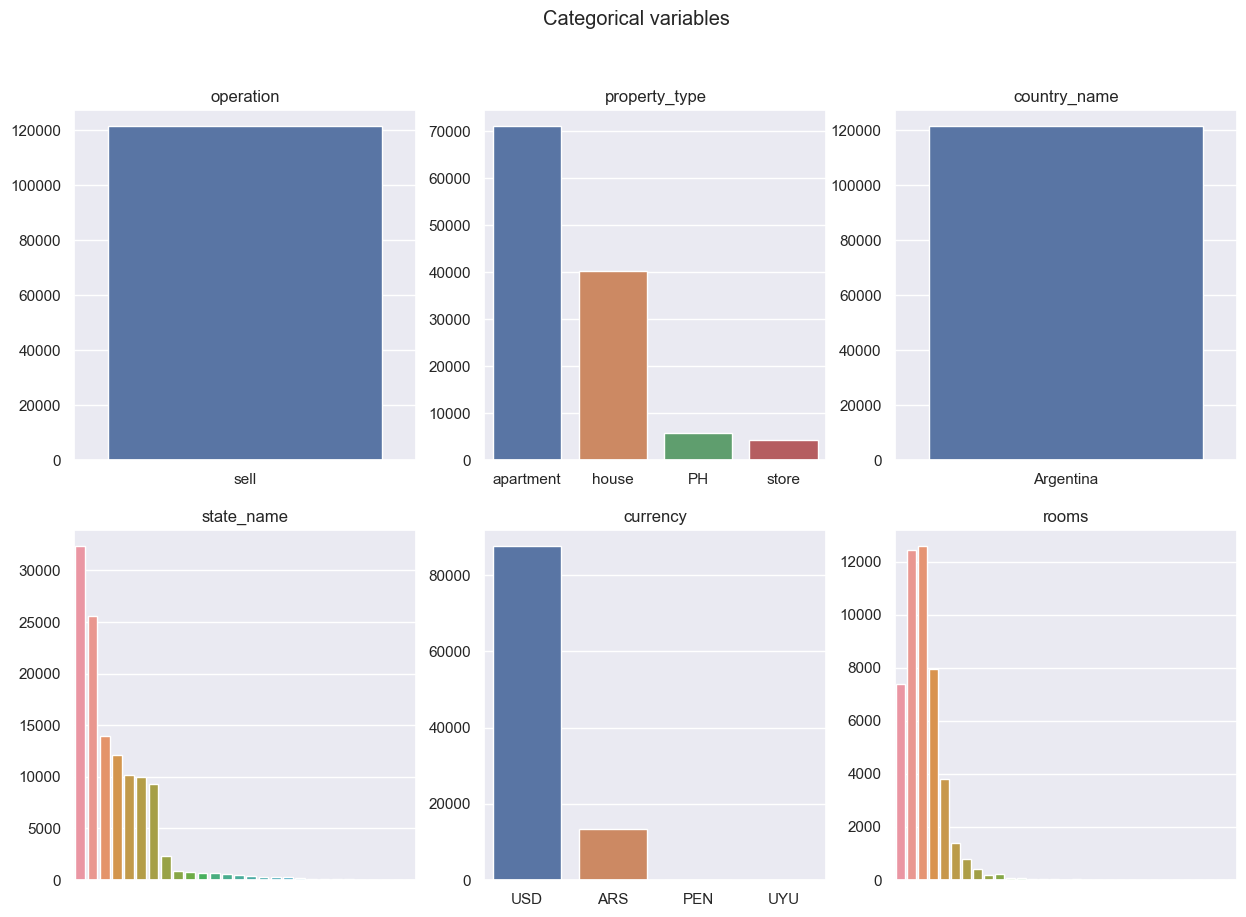

In [106]:
viz_categorical(df)

<br>

Para eliminar las constantes usaremos un one-liner / lambda function que representa la función a continuacion:

```python
def constant_check(dataframe):
    if isinstance(dataframe, pd.DataFrame) is True:
        for column in dataframe.columns:
            if len(dataframe[column].value_counts().index) == 1:
                dataframe = dataframe.drop(columns=[column])

    return dataframe
```

In [107]:
# Lambda function que realiza eliminación de series constantes
constant_check = lambda dataframe:  dataframe.drop(columns=[column for column in dataframe.columns if len(dataframe[column].value_counts().index) == 1]) if isinstance(dataframe, pd.DataFrame) is True else 'Not a dataframe'

# Realizamos la transformación
df = constant_check(df)
df.shape

(121220, 21)

# WIP

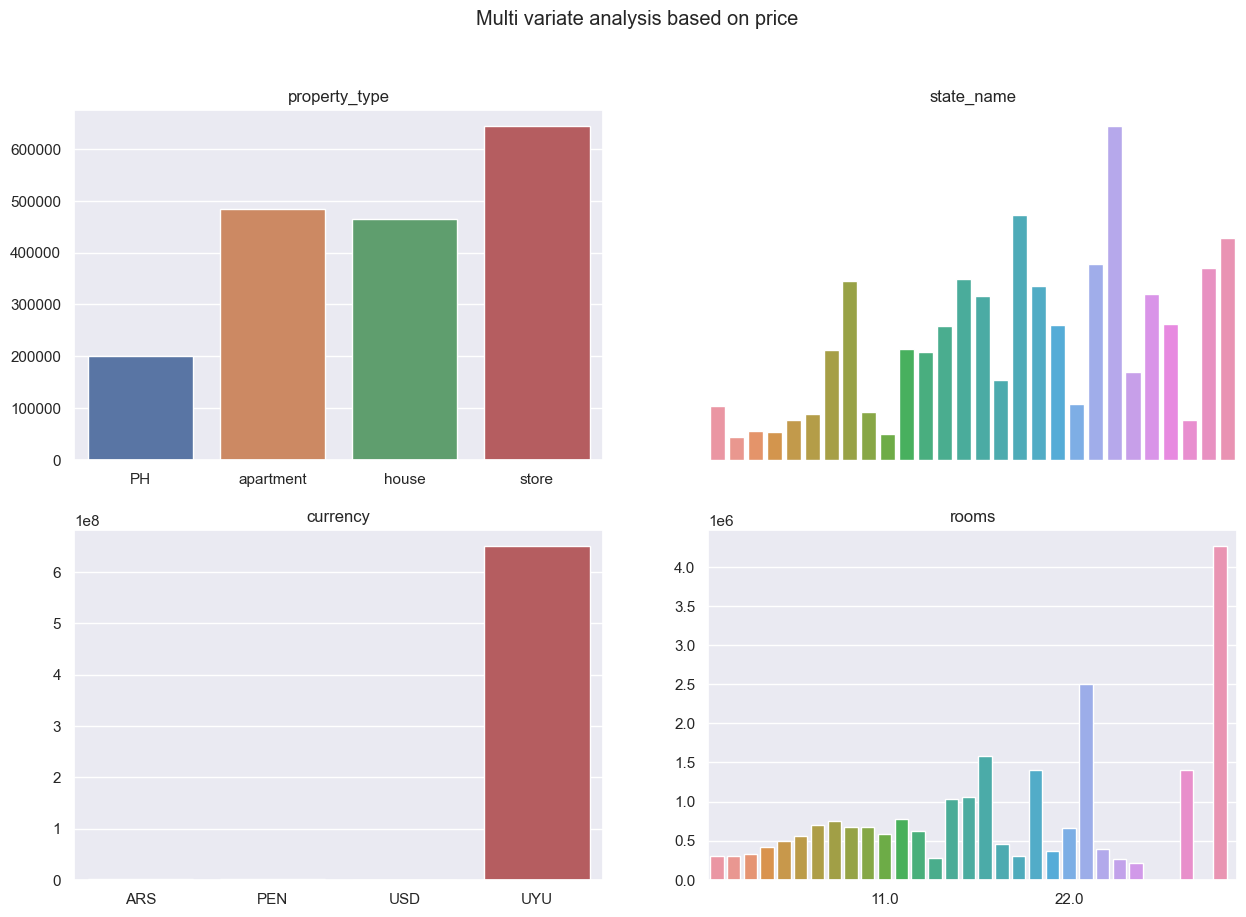

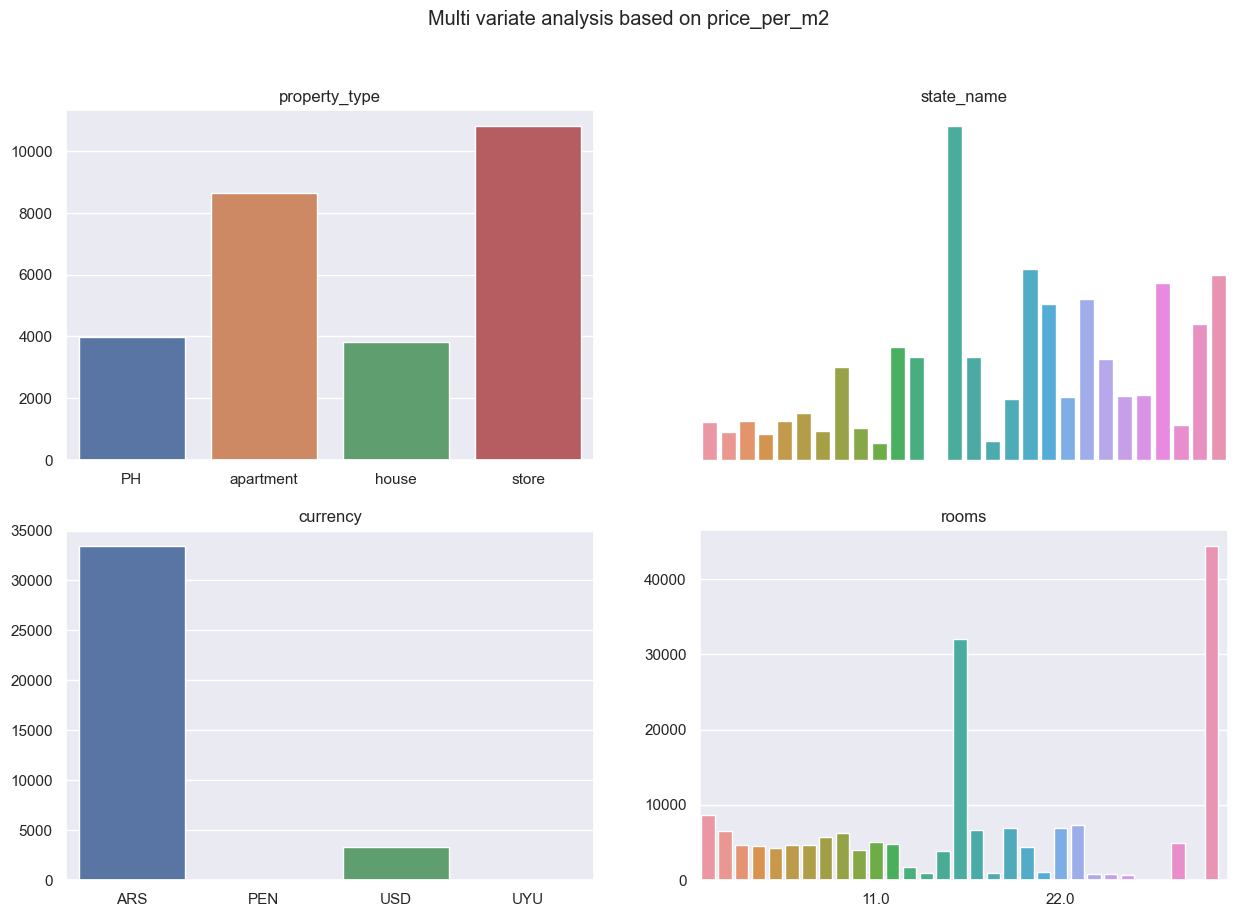

In [108]:
targets = ['price', 'price_per_m2']

def multi_variate_analysis(targets):
    columns = [column for column in df.columns if len(df[column].value_counts().index) > 1 and len(df[column].value_counts().index) < 50]

    if len(columns) % 2 == 0:
        rows = round(len(columns) / 2)
    else:
        rows = round(len(columns) / 2) + 1


    for target in targets:

        globals()['fig' + target], axes = plt.subplots(rows, 2, figsize=(15, 10))
        globals()['fig' + target].suptitle(f'Multi variate analysis based on {target}')


        for column, (i, ax) in zip(columns, enumerate(globals()['fig' + target].axes)):
            
            group_df = df[[column, target]].groupby(by=[column]).mean(target)
            sn.barplot(x=group_df.index.tolist(), y=group_df[target].tolist(), ax=ax)
            
            if df[column].dtype == 'float64':
                ax.set_xticks([round(len(df[column].value_counts().index)/3), round(len(df[column].value_counts().index)* (2/3)) , len(df[column].value_counts().index)])
            elif df[column].dtype == 'O' and len(df[column].value_counts().index) > 15:
                ax.set_axis_off()

            ax.set_title(column)

multi_variate_analysis(targets)

### Validación / Imputación mediante la columna description

A través dedescription validaremos e imputaremos varias columnas, puesto que estas parecen ser una descomposición de la primera. Por este motivo, lo primero que haremos es descartar aquellos registros cuya descripción es nula.

In [109]:
df.drop(index=df[df['description'].isnull() == True].index, inplace=True)
df[df['description'].isnull() == True].index

Int64Index([], dtype='int64')

In [110]:
fig = dat_insights(df, '', rtn=False)
fig.update_layout(title='<b>NaN Analysis')

Limpiando place_name column based on title and description columns

In [111]:
# Notas a discutir, 'place_with_parent_names' incluye todas las de zonas. Se podria dropear todas y dejar solo esa.
# ademas de eliminar cierto nivel de granularidad

temp_df = df[df['place_name'].isnull() == True]

for description, title, place, index in zip(temp_df['description'], temp_df['title'], temp_df['place_with_parent_names'], temp_df.index):
    for location in df['place_name'].value_counts().index:
        if location.lower() in description.lower():
            df['place_name'].loc[index] = location
        elif location.lower() in title.lower():
            df['place_name'].loc[index] = location
        elif location.lower() in place.lower():
            df['place_name'].loc[index] = location


if df[df['place_name'].isna() == True].shape[0] == 0:
    print('La columna place_name ha sido completamente imputada')

La columna place_name ha sido completamente imputada


In [ ]:
from spa2num.converter import to_number


for description, rooms, index in zip(df['description'], df['rooms'], df.index):
    if str(description) != 'nan':
        description = re.sub(' +', ' ', description.lower())
        start = description.lower().find('ambientes')
        
        if start != -1:
            temp_list = description.lower().split(' ')
            
            if 'ambientes' in temp_list:
                rooms_index = temp_list.index('ambientes') - 1
                rooms = temp_list[rooms_index]
                if isinstance(rooms, int) is True:
                    df['rooms'].loc[index] = rooms
                elif isinstance(rooms, str) is True:
                    if rooms == 'mono':
                        df['rooms'].loc[index] = 1
                    try:
                        rooms = to_number(rooms)
                        
                        if isinstance(rooms, int) is True:
                            df['rooms'].loc[index] = rooms
                    except:
                        print(description)


In [116]:
# que dropear:
# operation
# lat-long sacarla
# price_aprox_local_curerncy
# rooms
# country_name

#armar:
# ambientes a partir de description



df['state_name'].value_counts()

Capital Federal             32316
Bs.As. G.B.A. Zona Norte    25559
Bs.As. G.B.A. Zona Sur      13952
Córdoba                     12068
Santa Fe                    10172
                            ...  
Catamarca                      27
Jujuy                          26
Santa Cruz                     20
Santiago Del Estero             4
La Rioja                        4
Name: state_name, Length: 28, dtype: int64

In [117]:
table_dtype(df)

In [118]:
test = correlation_matrix(df, 'PROPERATY', rtn=False)

In [119]:
import plotly.io as pio
#
pio.show(test, engine='kaleido')
